<a href="https://colab.research.google.com/github/imorda/MetOpt-2023/blob/main/Lab_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Задачи, цели работы


## Цель работы
Изучение метода градиентного спуска и его различных модификаций, реализация этих методов на языке программирования Python 3, исследование их сходимости и эффективности на различных функциях, а также сравнительный анализ полученных результатов.


## Задачи для достижения указанной цели

1. Изучение теории метода градиентного спуска и его модификаций.
2. Реализация метода градиентного спуска с постоянным шагом, метода градиентного спуска с дроблением шага, метода градиентного спуска с оптимальным шагом на языке программирования Python 3.
3. Исследование сходимости и эффективности реализованных методов на различных функциях.
4. Сравнительный анализ полученных результатов и оценка преимуществ и недостатков каждого метода.
5. Практическое применение методов градиентного спуска в задачах оптимизации реальных функций.

# Ход работы

## Подготовка среды, определение полезных функций

###Импорты и задание стандартных констант

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)
np.set_printoptions(precision=2, suppress=False)

In [ ]:
def_visualization_area = ((-12, 12), (-12, 12))  # Область отрисовки графиков ((start, stop) x dims)
def_visualization_resolution = 100  # Количество точек визуализации вдоль одной оси
def_tol = 1e-5 #  Дефолтное значение tol 

###Блок необходимых математических функций

In [ ]:
def numeric_gradient(f,x, h=1e-6):
    """
    Функция для численного вычисления градиента функции f в точке x.
    Параметры:
        x: точка, в которой нужно вычислить градиент
        h: малое число для вычисления приближенного значения производной
    """
    n = x.shape[0]  # число переменных
    grad = np.zeros(n)  # инициализация градиента
    for i in range(n):
        x_plus = x.copy()
        x_plus[i] += h  # прибавляем малое число к i-ой координате
        x_minus = x.copy()
        x_minus[i] -= h  # вычитаем малое число из i-ой координаты
        grad[i] = (f(x_plus) - f(x_minus)) / (2 * h)  # вычисляем приближенное значение производной
    return grad


###Код, отвечающий за визуализацию процесса

In [ ]:
def calc_axes(visualization_area, visualization_resolution):
    """
    Функция, создающая необходимое количество осей и равномерно заполняющая
    их точками для дальнейших расчётов по этим точкам для визуализации
    """
    axes = []
    for start, stop in visualization_area:
      axes.append(np.linspace(start, stop, visualization_resolution))
    return axes


def visualize_descent(points, 
                      visualization_area=def_visualization_area,
                      visualization_resolution=def_visualization_resolution, 
                      print_points=False):
    """
    Функция для визуализации работы градиентного спуска на функции f. Первым 
    графиком выводится ломаная пар точек (iter, f(x)), получающихся в процессе работы метода,
    а на втором линии уровня функции f и точками отмечены шаги алгоритма.
    Параметры:
        points: шаги градиентного спуска
    """
    points = np.array(points)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    if print_points:
        print(points[:10])
        print("...")
        print(points[-10:])
    X, Y = np.meshgrid(*calc_axes(visualization_area, visualization_resolution))
    values = f(np.stack((X, Y)))
    ax2.contour(X, Y, values, levels=np.sort(np.concatenate((f(points.T), np.linspace(np.amin(values), np.amax(values), 100)))))
    ax1.plot(f(points.T))
    ax1.grid()
    ax2.plot(points[:, 0], points[:, 1], 'o-')
    ax1.set_xlabel("# of epoch", fontsize=20)
    ax1.set_ylabel("f(X)", fontsize=20)
    ax2.set_xlabel("X", fontsize=20)
    ax2.set_ylabel("Y", fontsize=20)
    fig.tight_layout(pad=5.0)


def visualize_2arg(visualization_area=def_visualization_area,
                   visualization_resolution=def_visualization_resolution):
    """
    Функция для отрисовки функции f 2х аргуметов
    """
    X, Y = np.meshgrid(*calc_axes(visualization_area, visualization_resolution))
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.plot_surface(X, Y, f(np.stack((X, Y))))
    ax.set_xlabel("$X$", fontsize=20)
    ax.set_ylabel("$Y$", fontsize=20)
    ax.set_zlabel("$f(x, y)$", fontsize=20, labelpad=-5)


def heatmap2d(x, y, arr: np.ndarray, nameX = "", nameY = ""):
    fig, ax = plt.subplots()
    plt.imshow(arr, cmap='viridis')
    cbar = plt.colorbar()
    cbar.ax.set_ylabel('Number of iterations')
    ax.set_xticks(np.arange(0, x.shape[1]), labels=x[0])
    ax.set_yticks(np.arange(0, x.shape[0]), labels=y.T[0])
    ax.set_ylabel(nameY)
    ax.set_xlabel(nameX)


def print_stats(iters, func_calls = -1,  grad_calls = -1, points=[(), ()]):
  print(f"""
    Начальная точка: {points[0]}
    Количество итераций: {iters}
    Количество вызовов функции: {func_calls}
    Количество вызовов градиента: {grad_calls}
    Конечная точка: {points[-1]}
  """)


## Задание 1. Реализация градиентного спуска с постоянным шагом (learning rate)


В ячейке ниже предтставлена реализация градиентного спуска с постоянным шагом. Алгоритм начинает двигаться из стартовой точки $x_0$ в сторону направления градиента, корректируемого константным множителем шага (`learning rate`). Градиент на каждом шаге вычисляется методом численного дифференцирования (описание его работы можно найти в ячейке выше). Завершение алгоритма происходит в двух случаях:

1. Достижение максимального количества итераций (`epoch`)
2. Достижение необходимой точности (малости) градиента (`tol`)

In [ ]:
def gradient_descent_constant_step(f, df, x0, lr, tol=def_tol, epoch=1000):
    """
    :param f: функция для оптимизации
    :type f: (X: ndarray[1]) -> Y: ndarray[1] 
    :param df: функция градиента f (\grad f)
    :type df: (X: ndarray[1]) -> Y: ndarray[1] 
    :param x0: стартовая точка
    :type x0: ndarray[1]
    :param lr: learning rate (шаг)
    :type lr: float
    :param tol: tolerance (отсечение по модулю градиента)
    :type tol: float
    :param epoch: epoch (отсечение по количеству итеграций)
    :type epoch: int
    :return: кортеж из найденной точки экстремума, значения функции в этой точке, число выполненных итераций и  шаги (в ходе работы)
    :rtype: (ndarry[1], ndarray[1], int, ndarray[1])
    """
    points = [x0]
    for i in range(epoch):
        x = points[-1]
        grad = df(f,x)
        # print(np.linalg.norm(grad))
        if np.linalg.norm(grad) < tol:
            break
        points.append(x - lr * grad)
    return x, f(x), i+1, points

Пример работы градиентного спуска на примере функции Букина:

$f(x, y) = 100 \sqrt{|y - 0.01 \cdot x^2|} + 0.01 \cdot |x + 10|$. 

Для начала зададим функцию и отрисуем её:



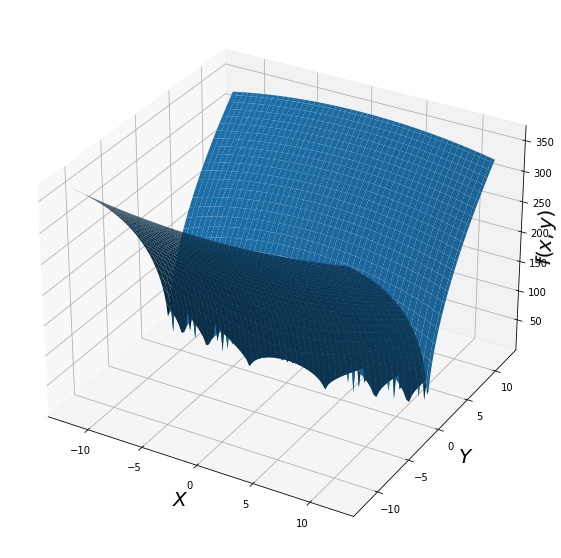

In [ ]:
def f_bukin(x):
    return 100 * np.sqrt(np.abs(x[1] - 0.01 * x[0] ** 2)) + 0.01 * np.abs(x[0] + 10)
f = f_bukin
visualize_2arg()

Применяем метод градиентного спуска с параметрами `learning_rate = 0.008`, `epoch = 100`, $x_0 = (12, -10)$

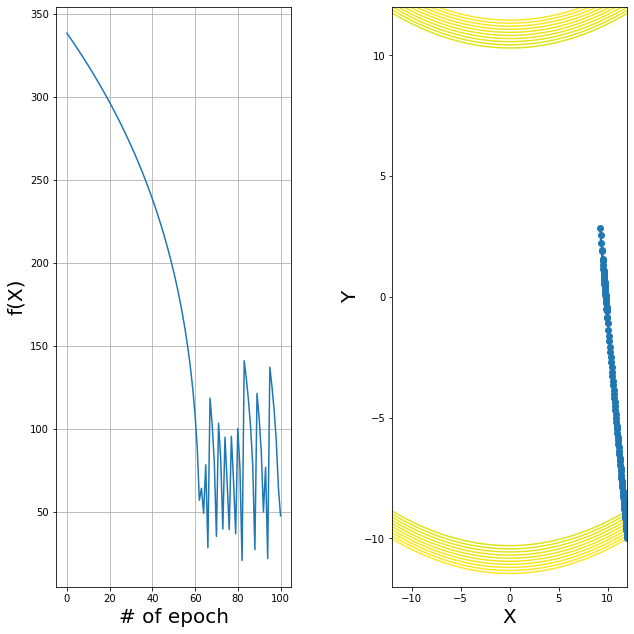

In [ ]:
lr = 0.008
epoch = 100
x0 = np.array([12.0, -10.0])

_, _, _, points = gradient_descent_constant_step(f, numeric_gradient, x0, lr, epoch=epoch)
visualize_descent(points)

## Задание 2. Реализация метода дихотомии и градиентного спуска на его основе



Реализуем метод дихотомии и градиентный спуск на его основе. В отличии от своего "постоянного" собрата, метод на основе дихотомии меняет длину шага на каждой итерации, подбирая такой $t \in [0, learning\_rate]$, чтобы на следующей точке $x' = x - t \cdot \nabla f(x)$ достигался локальный минимум функции $f(x)$. Сам метод градиентного спуска отличается только в строчке перехода к новой точке, в которой теперь применяется метод дихотомии.

In [ ]:
def dichotomy(f, a, b, l):
    """
    Реализация лиенйного поиска с помощью метода дихотомии
 
    :param function f
    :param float a: начало отрезка
    :param float b: конец отрезка
    :param float l: искомая длина шага
    """
    eps = l/5
    func_calls = 0
    while (b - a) > l:
        y = (a + b + eps) / 2
        z = (a + b - eps) / 2
        if f(y) > f(z):
            b = z
        else:
            a = y

        func_calls += 2
    return func_calls, (a + b) / 2


def grad_descent_with_dichotomy(f, df, x0, lr, tol=def_tol, epoch=1000):
  """
  :param f: Исследуемая функция
  :param df: Функция вычисления градиента
  :param x0: Начальная точка
  :param lr: Learning rate
  :param tol: Условие останова по достижению необходимой точности (нормы градиента)
  :param epoch: Ограничение числа итераций
  :return: Кортеж из точек, кол-ва вызовов функции f, количества итераций
  """
  points = [x0]
  func_calls_cummulative = 0
  for i in range(1, epoch):
      x = points[-1]
      grad = df(f,x)
      # print(np.linalg.norm(grad))
      if np.linalg.norm(grad) < tol:
        break
      func_calls, t = dichotomy(lambda t: f(x - t*grad),0, lr, lr/1e3)
      func_calls_cummulative += func_calls
      points.append(x - t * grad)

  return points, func_calls_cummulative, len(points)

Продемонстрируем работу метода на примере функции той же функции Букина N6 $f(x, y) = 100 \sqrt{|y - 0.01 \cdot x^2|} + 0.01 \cdot |x + 10|$ с параметрами `learning_rate = 0.008`, `epoch = 100`, $x_0 = (15, -10)$


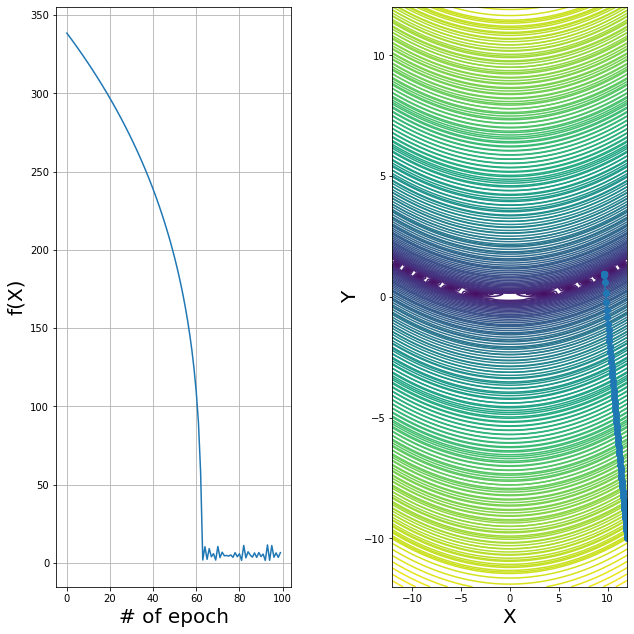

In [ ]:
lr = 0.008
epoch = 100
x0 = np.array([12.0, -10.0])

points, _, _ = grad_descent_with_dichotomy(f, numeric_gradient, x0, lr, epoch=epoch)
visualize_descent(points)

Обратите внимание, что при одинаковых параметрах амплитуда колебания значений функций гораздо меньше, чем в методе с константным шагом. Отдельно отметим, что теперь мы можем увеличить максимальный `learning_rate`, тем самым кардинально увеличив скорость сходимости: (`learning_rate = 0.05`)

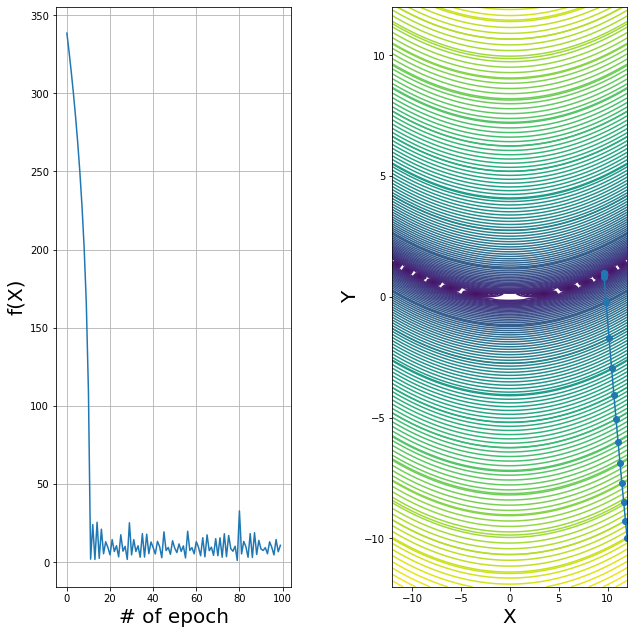

In [ ]:
lr = 0.05
epoch = 100
x0 = np.array([12.0, -10.0])

points, _, _ = grad_descent_with_dichotomy(f, numeric_gradient, x0, lr, epoch=epoch)
visualize_descent(points)

## Задание 3. Демонстрация работы рассматриваемых методов на квадратичных функциях

### Задание квадратичных функций
Предлагаем рассмотреть следующие квадратичные функции, на которых можно проанализировать работу методов градиентного спуска:

#### $g(x, y) = x^2 + 2y^2$
Выпуклая функция, в районе минимума которой градиентный спуск с константным шагом будет "перепрыгивать" точку минимума.

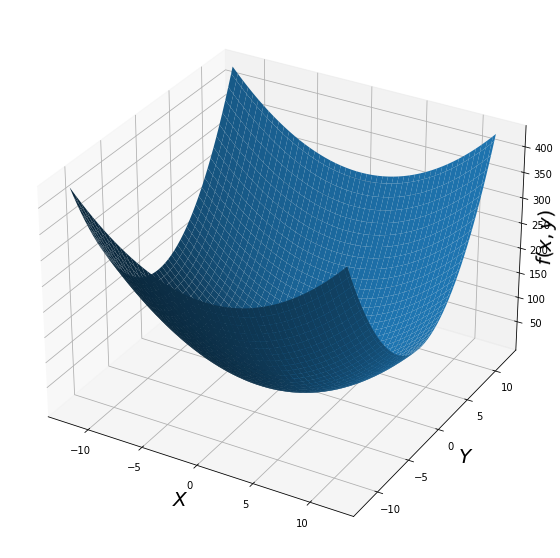

In [ ]:
def g(x):
  return x[0] ** 2 + 2 * x[1] ** 2
f = g
visualize_2arg()

#### $h(x, y) = 500x^2 + 0.001y^2 + x + y$
Функция с большим числом обусловленности.

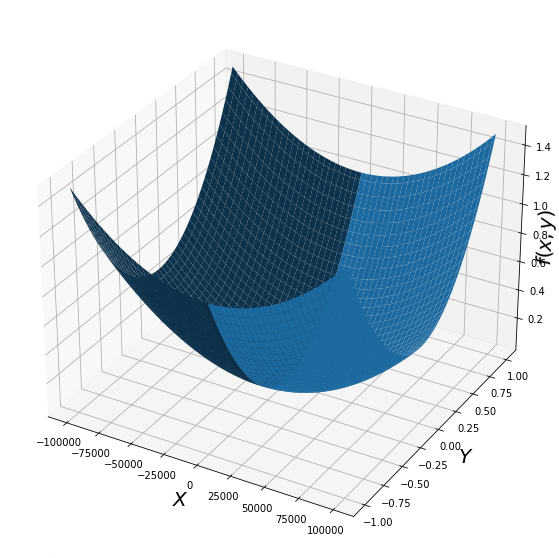

In [ ]:
def h(x):
  return 500 * x[0] ** 2 + 0.001 * x[1] ** 2 + x[0] + x[1]
f = h
visualize_2arg(visualization_area = ((-100000, 100000), (-100000000, 100000000)))

#### $w(x, y) = x^2 - 2xy + y^2 + x - y$
Функция, имеющая бесконечное число минимумов, следовательно результат работы алгоритма будет сильно зависеть от выбора начальной точки.

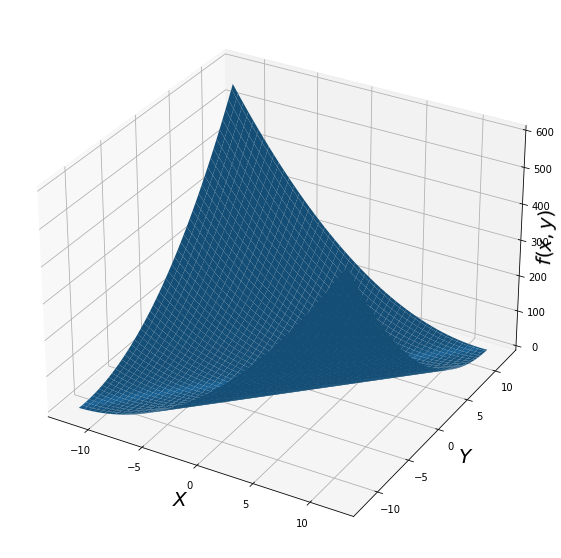

In [ ]:

def w(x):
  return x[0] ** 2 - 2 * x[0] * x[1] + x[1] ** 2 + x[0] - x[1]
f = w
visualize_2arg()

### Работа градиентного спуска с постоянным шагом и с использованием метода дихотомии

In [ ]:
lr = 0.08
epoch = 1000
x0 = np.array([1.0, -1.0])

#### $g(x, y) = x^2 + 2y^2$

Постоянный шаг:

    Начальная точка: [ 12. -10.]
    Количество итераций: 100
    Количество вызовов функции: 101
    Количество вызовов градиента: 101
    Конечная точка: [ 2.39 -0.39]
  


NameError: ignored

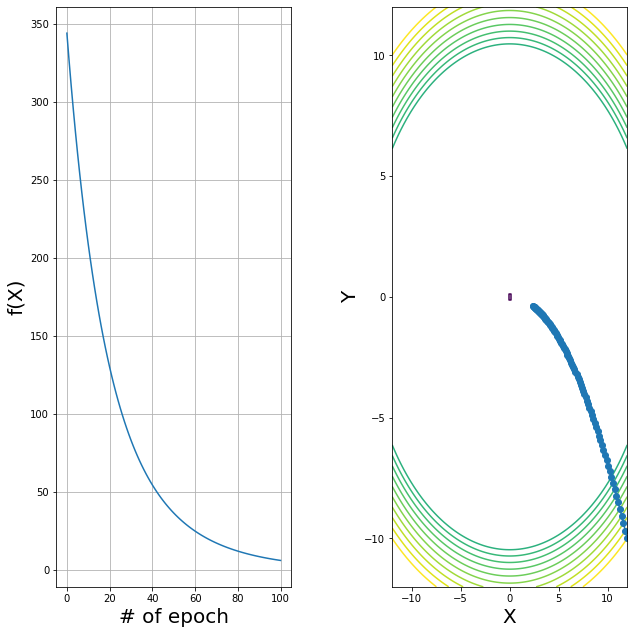

In [ ]:
f = g
_, _, iters, points = gradient_descent_constant_step(f, numeric_gradient, x0, lr, epoch=epoch)
print("Постоянный шаг:")
print_stats(iters, len(points), len(points), points)
visualize_descent(points)
points, func_calls, grad_calls = grad_descent_with_dichotomy(f, numeric_gradient, x0, lr, epoch=epoch)
print("Дихотомия:")
print_stats(len(points), func_calls, grad_calls, points)
visualize_descent(points)

#### $h(x, y) = 500x^2 + 0.001y^2 + x + y$


Постоянный шаг:

    Начальная точка: [ 1. -1.]
    Количество итераций: 865
    Количество вызовов функции: 865
    Количество вызовов градиента: 865
    Конечная точка: [-3.06e-05 -1.01e+00]
  
Постоянный шаг побольше:

    Начальная точка: [ 1. -1.]
    Количество итераций: 14
    Количество вызовов функции: 14
    Количество вызовов градиента: 14
    Конечная точка: [-1.88e+11 -1.04e+00]
  
Дихотомия:

    Начальная точка: [ 1. -1.]
    Количество итераций: 3
    Количество вызовов функции: 40
    Количество вызовов градиента: 3
    Конечная точка: [-7.05e-04 -1.00e+00]
  


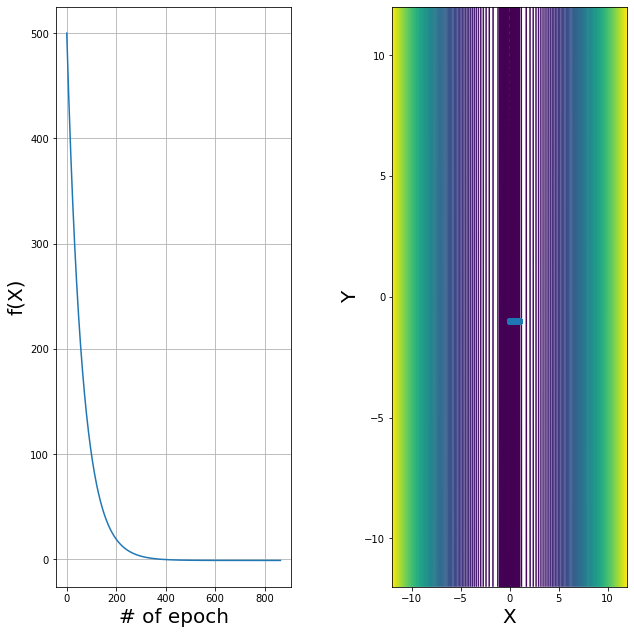

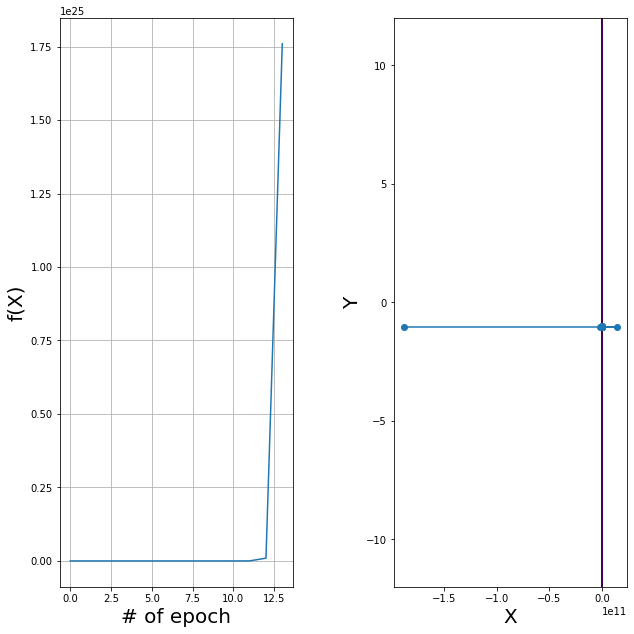

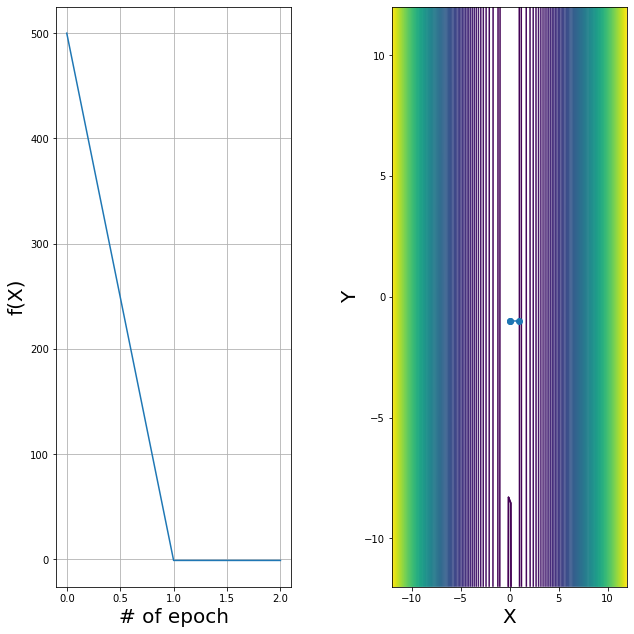

In [ ]:
lr = 0.000008
visualization_area = ((-10, 10), (-100, 100))
f = h

# градиентный спуск с маленьким константным шагом
_, _, iters, points = gradient_descent_constant_step(f, numeric_gradient, x0, lr, epoch=epoch, tol = 1.3937)
print("Постоянный шаг:")
print_stats(iters, len(points), len(points), points)
visualize_descent(points)

# то же самое, только с шагом побольше
lr = 0.008
_, _, iters, points = gradient_descent_constant_step(f, numeric_gradient, x0, lr, epoch=epoch, tol = 1.3937)
print("Постоянный шаг побольше:")
print_stats(iters, len(points), len(points), points)
visualize_descent(points)

# градиентный спуск на основе метода дихотомии
points, func_calls, grad_calls = grad_descent_with_dichotomy(f, numeric_gradient, x0, lr, epoch=epoch, tol = 1.3937)
print("Дихотомия:")
print_stats(len(points), func_calls, grad_calls, points)
visualize_descent(points)

visualization_area = ((-12, 12), (-12, 12))

#### $w(x, y) = x^2 - 2xy + y^2 + x - y$

Постоянный шаг:

    Начальная точка: [ 1. -1.]
    Количество итераций: 416
    Количество вызовов функции: 416
    Количество вызовов градиента: 416
    Конечная точка: [-0.25  0.25]
  
Дихотомия:

    Начальная точка: [ 1. -1.]
    Количество итераций: 416
    Количество вызовов функции: 8300
    Количество вызовов градиента: 416
    Конечная точка: [-0.25  0.25]
  


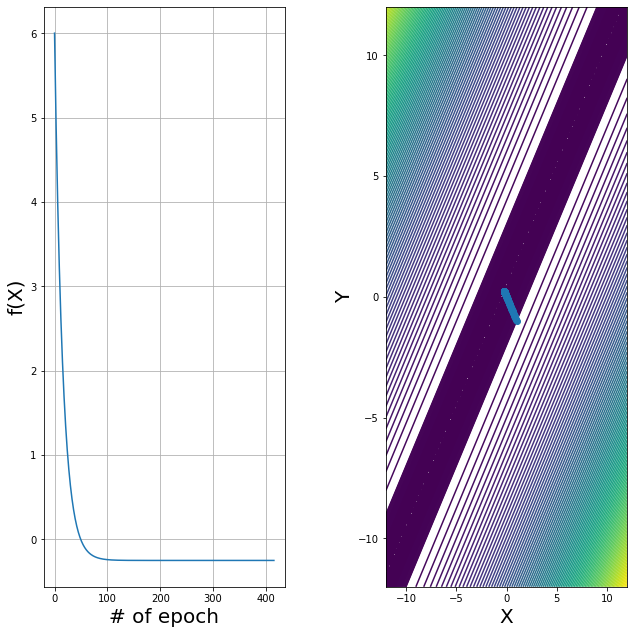

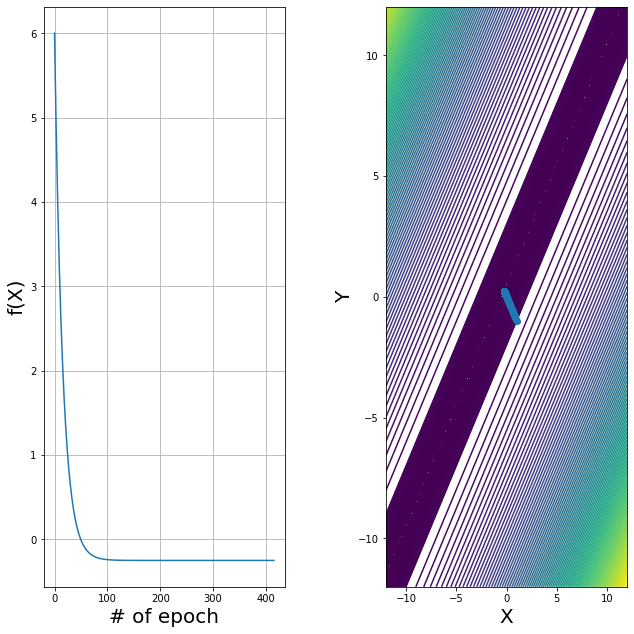

In [ ]:
f = w
_, _, iters, points = gradient_descent_constant_step(f, numeric_gradient, x0, lr, epoch=epoch)
print("Постоянный шаг:")
print_stats(iters, len(points), len(points), points)

visualize_descent(points)
points, func_calls, grad_calls = grad_descent_with_dichotomy(f, numeric_gradient, x0, lr, epoch=epoch)
print("Дихотомия:")
print_stats(len(points), func_calls, grad_calls, points)
visualize_descent(points)

#### Выводы
Как мы видим, метод дихотомии позволяет незначительно ускорить сходимость градиентного спуска в контексте квадратичной функции и более точно находить минимум функции, так как в окрестности этого минимума шаг обучения значительно уменьшается, что уменьшает флуктуации спуска.

Однако, в выбранных квадратричных функциях эти эффекты практически незаметны. С другой стороны, выбранная плохо обусловленная функция $h$ показывает другую проблему: при обычном значении `learning_rate` не получается добиться сходимости, так как в какой-то момент градиентный спуск перепрыгивает минимум вдоль оси с большим коэффициентом из-за чего значение функции стремительно улетает вверх (см. вторую строку графиков)

В обратной ситуации, если поставить маленький `learning_rate`, сходимость появляется, но слишком медленно, количество итераций возрастает на порядок (см. первую строку графиков)

Метод дихотомии же полностью решает эту проблему, мы можем безопасно увеличить `learning_rate`, так как дихотомия уменьшит его в окрестности минимума функции и минимум будет найден достаточно быстро (см. третью строку графиков)

## Задание 4. Анализ применимости методов оптимизации к различным квадратичным функциям

### Сравнительное исследование сходимости градиентного спуска с постоянным шагом

В задании 3 мы, помимо отрисовки функций, также собрали статистику по работе методов. В таблице ниже представлены необходимые количества шагов для сходимости функций при использовании метода градиентного спуска с константным шагом на одинаковом наборе аргументов (`learning_rate = 0.08`, `epoch = 1000`, `tol = 0.001`, $x_0 = (1, -1)$):

| Функция | Количество итераций |
|---|---|
| $g(x, y)$ | 45 |
| $h(x, y)$ | 865 |
| $w(x, y)$ | 274 |

Несмотря на то, что все исследуемые функции --- квадратичные, понадобилось сильно разное количество итераций для достижения сходимости. Рассмотрим каждый случай отдельно: 

1. Функция представляет из себя стандартную "чашу", почти не растянутую по сторонам, и причём достаточно широкую, что позволяяет достичь минимума даже с нашим выбором параметров (конкретно `learning_rate`)

2. Эта же функция характеризуется плохим числом обусловленности, вследстивие чего по одной оси она сильно растянута, а по другой --- ещё сильнее сжата. Поэтому сходимость осущствляется очень медленно, а если выбрать большой шаг, то метод просто "проскользнёт" мимо функции и в итоге разойдётся.

3. Данная функция имеет бесконечное количество минимумов, плюс мы выбрали достаточно маленький шаг. Но относительно предыдущей функции сошлось достаточно быстро.

### Сравнение эффективности градиентного спуска с использованием метода дихотомии с точки зрения количества вычислений функции и её градиентов

| Функция                                 | g(x,y)    | h(x,y)    | w(x,y)   |
|-----------------------------------------|-----------|-----------|----------|
Количество вызовов функции(дихотомия)     |880 |40  |5460|
Количество вызовов градиента (дихотомия)  |45  |3   |274|
Количество вычислений функции (дихотомия) |970 |46  |6008|
Количество шагов (дихотомия)              |45  |3   |274|
Количество вызовов функции (константа)    |473 |865 |274|
Количество вызовов градиента (константа)  |473 |865 |274|
Количество вычислений функции (константа) |1419|2595|822|
Количество шагов (константа)              |473 |865 |274|

Данная таблица показывает, что дихотомия значительно увеличивает число вычислений функции, так как вычисляет наименьшее её значение вдоль направления градиента. Однако, в случае плохо обусловленной функции, данный метод значительно снижает число необходимых итераций благодаря ускорению сходимости даже при большом `learning_rate`. В таком случае, увеличившееся число вычислений функции сразу компенсируется, что мы и видим в функции $h$, где понадобилось всего 3 итерации для достижения минимума функции с необходимой точностью.

### Исследование зависимости работы методов оптимизации от выбора начальной точки

Определим некоторое множество начальных точек для дальнейших испытаний:

In [ ]:
start_points = np.array([[0, 0], 
                         [0.5, 0.5], 
                         [0.5, -0.5], 
                         [-3, -3], 
                         [-3, 3], 
                         [3, 0], 
                         [-3, 0], 
                         [0, 3], 
                         [0, -3], 
                         [100, 100], 
                         [-100, -100], 
                         [-100, 0], 
                         [0, 100]]) 

In [ ]:
def analyze_start_points(lr=lr, tol=def_tol):
    print("|Начальная точка | Конечная точка при пост. шаге|Конечная точка при дихотомии| Кол-во шагов при пост. шаге| Кол-во шагов при дихотомии|")
    print("|-|-|-|-|-|")
    for i in start_points:
        _, _, iters, points1 = gradient_descent_constant_step(f, numeric_gradient, i, lr, epoch=epoch, tol=tol)
        points2, func_calls, grad_calls = grad_descent_with_dichotomy(f, numeric_gradient, i, lr, epoch=epoch, tol=tol)
        print(f"|{i} | {points1[-1]}|{points2[-1]}|{len(points1)}| {len(points2)}|")

#### $g(x, y) = x^2 + 2y^2$

In [ ]:
f = g
analyze_start_points(tol=0.01)

|Начальная точка | Конечная точка при пост. шаге|Конечная точка при дихотомии| Кол-во шагов при пост. шаге| Кол-во шагов при дихотомии|
|-|-|-|-|-|
|[0. 0.] | [0. 0.]|[0. 0.]|1| 1|
|[0.5 0.5] | [4.96e-03 4.56e-05]|[4.97e-03 4.58e-05]|287| 287|
|[ 0.5 -0.5] | [ 4.96e-03 -4.56e-05]|[ 4.97e-03 -4.58e-05]|287| 287|
|[-3. -3.] | [-4.97e-03 -7.41e-06]|[-4.98e-03 -7.44e-06]|398| 398|
|[-3.  3.] | [-4.97e-03  7.41e-06]|[-4.98e-03  7.44e-06]|398| 398|
|[3. 0.] | [0. 0.]|[0. 0.]|398| 398|
|[-3.  0.] | [-0.  0.]|[-0.  0.]|398| 398|
|[0. 3.] | [0. 0.]|[0. 0.]|220| 220|
|[ 0. -3.] | [ 0. -0.]|[ 0. -0.]|220| 220|
|[100. 100.] | [4.92e-03 2.06e-07]|[4.94e-03 2.07e-07]|616| 616|
|[-100. -100.] | [-4.92e-03 -2.06e-07]|[-4.94e-03 -2.07e-07]|616| 616|
|[-100.    0.] | [-0.  0.]|[-0.  0.]|616| 616|
|[  0. 100.] | [0. 0.]|[0. 0.]|327| 327|


|Начальная точка | Конечная точка при пост. шаге|Конечная точка при дихотомии| Кол-во шагов при пост. шаге| Кол-во шагов при дихотомии|
|-|-|-|-|-|
|[0. 0.] | [0. 0.]|[0. 0.]|1| 1|
|[0.5 0.5] | [4.96e-03 4.56e-05]|[4.97e-03 4.58e-05]|287| 287|
|[ 0.5 -0.5] | [ 4.96e-03 -4.56e-05]|[ 4.97e-03 -4.58e-05]|287| 287|
|[-3. -3.] | [-4.97e-03 -7.41e-06]|[-4.98e-03 -7.44e-06]|398| 398|
|[-3.  3.] | [-4.97e-03  7.41e-06]|[-4.98e-03  7.44e-06]|398| 398|
|[3. 0.] | [0. 0.]|[0. 0.]|398| 398|
|[-3.  0.] | [-0.  0.]|[-0.  0.]|398| 398|
|[0. 3.] | [0. 0.]|[0. 0.]|220| 220|
|[ 0. -3.] | [ 0. -0.]|[ 0. -0.]|220| 220|
|[100. 100.] | [4.92e-03 2.06e-07]|[4.94e-03 2.07e-07]|616| 616|
|[-100. -100.] | [-4.92e-03 -2.06e-07]|[-4.94e-03 -2.07e-07]|616| 616|
|[-100.    0.] | [-0.  0.]|[-0.  0.]|616| 616|
|[  0. 100.] | [0. 0.]|[0. 0.]|327| 327|

Как видим, выбор точки почти никак не влияет на сходимость. Функция имеет только один локальный минимум, он же глобальный. Таким образом, при любой начальной точке всё сходится к одной и той же точке. Однако, в некоторых точках, которые сильно удалены от точки минимума, градиент очень большой, в результате чего, число шагов градиентного спуска с постоянным шагом увеличивается примерно в 2 раза. Вероятно, поскольку мы никак не ограничиваем сверху размер шага итерации, большое значение градиента приводит к "перепрыгиванию" минимума и соответствующей раскачке. Дихотомия лишена этого недостатка. 

#### $h(x, y) = 500x^2 + 0.001y^2 + x + y$


In [ ]:
f = h
analyze_start_points(lr=0.008, tol=1.25)

|Начальная точка | Конечная точка при пост. шаге|Конечная точка при дихотомии| Кол-во шагов при пост. шаге| Кол-во шагов при дихотомии|
|-|-|-|-|-|
|[0. 0.] | [ 2.91e+10 -7.15e-02]|[-1.99e-03 -1.99e+00]|17| 1000|
|[0.5 0.5] | [-4.37e+10  4.60e-01]|[-3.99e-04  4.98e-01]|14| 3|
|[ 0.5 -0.5] | [-4.37e+10 -5.70e-01]|[-3.99e-04 -5.02e-01]|14| 3|
|[-3. -3.] | [-3.65e+10 -3.05e+00]|[-1.11e-03 -3.00e+00]|13| 3|
|[-3.  3.] | [-3.65e+10  2.97e+00]|[-1.11e-03  3.00e+00]|13| 3|
|[3. 0.] | [ 3.62e+10 -4.71e-02]|[-0. -0.]|13| 3|
|[-3.  0.] | [-3.65e+10 -4.71e-02]|[-0. -0.]|13| 3|
|[0. 3.] | [2.90e+10 2.93e+00]|[-0.    0.99]|17| 1000|
|[ 0. -3.] | [ 2.90e+10 -3.07e+00]|[-1.97e-03 -4.98e+00]|17| 1000|
|[100. 100.] | [2.14e+10 1.00e+02]|[-2.34e-03  9.76e+01]|11| 1000|
|[-100. -100.] | [-2.56e+10 -1.00e+02]|[-4.15e-04 -1.00e+02]|11| 4|
|[-100.    0.] | [-2.56e+10 -2.37e-02]|[-9.13e-05 -2.01e+00]|11| 1000|
|[  0. 100.] | [2.91e+10 9.99e+01]|[-2.46e-03  9.75e+01]|17| 1000|


|Начальная точка | Конечная точка при пост. шаге|Конечная точка при дихотомии| Кол-во шагов при пост. шаге| Кол-во шагов при дихотомии|
|-|-|-|-|-|
|[0 0] | [0 0]|[0 0]|1| 1|
|[0.5 0.5] | ~[-4.37e+10  4.60e-01]~|[-3.99e-04  4.98e-01]|~14~| 3|
|[ 0.5 -0.5] | ~[-4.37e+10 -5.70e-01]~|[-3.99e-04 -5.02e-01]|~14~| 3|
|[-3 -3] | ~[ 2.59e+10 -3.98e+03]~|[-1.14e-03 -4.55e+00]|~6~| 5|
|[-3  3] | ~[ 2.59e+10 -4.02e+03]~|[-1.14e-03  1.44e+00]|~6~| 5|
|[3 0] | ~[-2.17e+10  0.00e+00]~|[-0. -0.]|~6~| 5|
|[-3  0] | ~[2.59e+10 0.00e+00]~|[-0. -0.]|~6~| 5|
|[0 3] | ~[ 2.90e+10 -4.02e+03]~|[   0.   -501.16]|~18~| 2|
|[ 0 -3] | ~[ 2.90e+10 -3.98e+03]~|[   0.   -498.26]|~18~| 2|
|[100 100] | ~[-2.02e+10 -4.70e+03]~|[-1.24e-03  9.81e+01]|~4~| 6|
|[-100 -100] | ~[ 1.81e+10 -3.30e+03]~|[-8.94e-04 -1.01e+02]|~4~| 6|
|[-100    0] | ~[1.81e+10 0.00e+00]~|[-0. -0.]|~4~| 6|
|[  0 100] | ~[ 2.9e+10 -4.7e+03]~|[   0.   -501.48]|~18~| 2|

Здесь всё аналогично, но ввиду очень резкого роста данной функции, спуск с постоянным шагом не может добиться сходимости с `learning_rage=0.008` совсем. Причина та же: слишком большие значения градиента вдали от минимума заставляют функцию градиентного спуска с постоянным шагом "перепрыгивать" минимум так, что результирующий ряд вообще расходится. Небольшие числа в столбце "Кол-во шагов при пост. шаге" лишь обусловлены тем, что в какой-то момент происходит переполнение и градиентный спуск сразу завершается.

Однако, сам выбор начальной точки никак не влияет на результат.

#### $w(x, y) = x^2 - 2xy + y^2 + x - y$

In [ ]:
f = w
analyze_start_points(lr=0.08, tol=0.1)

|Начальная точка | Конечная точка при пост. шаге|Конечная точка при дихотомии| Кол-во шагов при пост. шаге| Кол-во шагов при дихотомии|
|-|-|-|-|-|
|[0. 0.] | [-0.23  0.23]|[-0.23  0.23]|8| 8|
|[0.5 0.5] | [0.27 0.73]|[0.27 0.73]|8| 8|
|[ 0.5 -0.5] | [-0.23  0.23]|[-0.23  0.23]|11| 11|
|[-3. -3.] | [-3.23 -2.77]|[-3.23 -2.77]|8| 8|
|[-3.  3.] | [-0.26  0.26]|[-0.26  0.26]|15| 15|
|[3. 0.] | [1.27 1.73]|[1.27 1.73]|13| 13|
|[-3.  0.] | [-1.76 -1.24]|[-1.76 -1.24]|13| 13|
|[0. 3.] | [1.24 1.76]|[1.24 1.76]|13| 13|
|[ 0. -3.] | [-1.73 -1.27]|[-1.73 -1.27]|13| 13|
|[100. 100.] | [ 99.77 100.23]|[ 99.77 100.23]|8| 8|
|[-100. -100.] | [-100.23  -99.77]|[-100.23  -99.77]|8| 8|
|[-100.    0.] | [-50.27 -49.73]|[-50.27 -49.73]|22| 22|
|[  0. 100.] | [49.73 50.27]|[49.73 50.27]|22| 22|


|Начальная точка | Конечная точка при пост. шаге|Конечная точка при дихотомии| Кол-во шагов при пост. шаге| Кол-во шагов при дихотомии|
|-|-|-|-|-|
|[0. 0.] | [-0.23  0.23]|[-0.23  0.23]|8| 8|
|[0.5 0.5] | [0.27 0.73]|[0.27 0.73]|8| 8|
|[ 0.5 -0.5] | [-0.23  0.23]|[-0.23  0.23]|11| 11|
|[-3. -3.] | [-3.23 -2.77]|[-3.23 -2.77]|8| 8|
|[-3.  3.] | [-0.26  0.26]|[-0.26  0.26]|15| 15|
|[3. 0.] | [1.27 1.73]|[1.27 1.73]|13| 13|
|[-3.  0.] | [-1.76 -1.24]|[-1.76 -1.24]|13| 13|
|[0. 3.] | [1.24 1.76]|[1.24 1.76]|13| 13|
|[ 0. -3.] | [-1.73 -1.27]|[-1.73 -1.27]|13| 13|
|[100. 100.] | [ 99.77 100.23]|[ 99.77 100.23]|8| 8|
|[-100. -100.] | [-100.23  -99.77]|[-100.23  -99.77]|8| 8|
|[-100.    0.] | [-50.27 -49.73]|[-50.27 -49.73]|22| 22|
|[  0. 100.] | [49.73 50.27]|[49.73 50.27]|22| 22|

Здесь выводы немного другие. Проблема с большим градиентом и раскачкой тоже есть, на точках (-100, 0) и (0, 100) проявляется. Дихотомия так же лишена этой проблемы.

Однако, в этой функции существует целый ряд минимумов: все точки вдоль прямой $y = x + 0.5$. Соответственно, методы оптимизации будут сходиться к каким-то точкам минимума. Есть тенденция к сходимости к *ближайшей* точке минимума, но, в некоторых точках обозначенная проблема так же касается метода дихотомии, так как в некоторых "крайних случаях" линейный поиск может не найти искомую точку минимума и один раз рассматриваемая точка всё-таки "улетит" в сторону, но после этого, скорее всего, случай уже будет не "крайний" и дальше сходимость продолжится нормально:


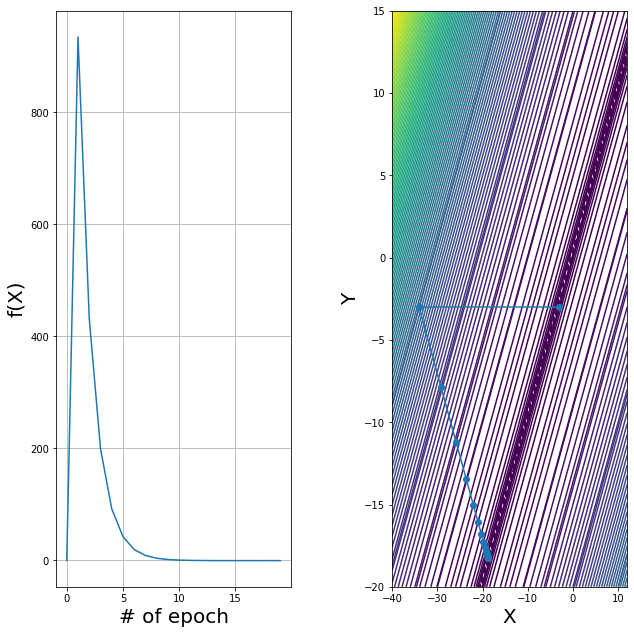

In [ ]:
start_x = np.array([-3, -3])
points, _, _ = grad_descent_with_dichotomy(f, numeric_gradient, start_x, lr=0.08, epoch=epoch, tol=0.1)
visualize_descent(points, visualization_area = ((-40, 12), (-20, 15)))

#### Вывод
Таким образом, выбор начальной точки может повлиять на сходимость градиентного спуска с постоянным шагом, однако не влияет на работу спуска с дихотомией. 

Ну а если точек минимума несколько, выбор начальной точки может поменять конечную точку, к которой сойдётся градиентрый спуск.

### Исследование влияния нормализации плохо обусловленной функции на сходимость

#### Плохо обусловленная функция
#### $h(x,y)=500x^2+0.001y^2+x+y$

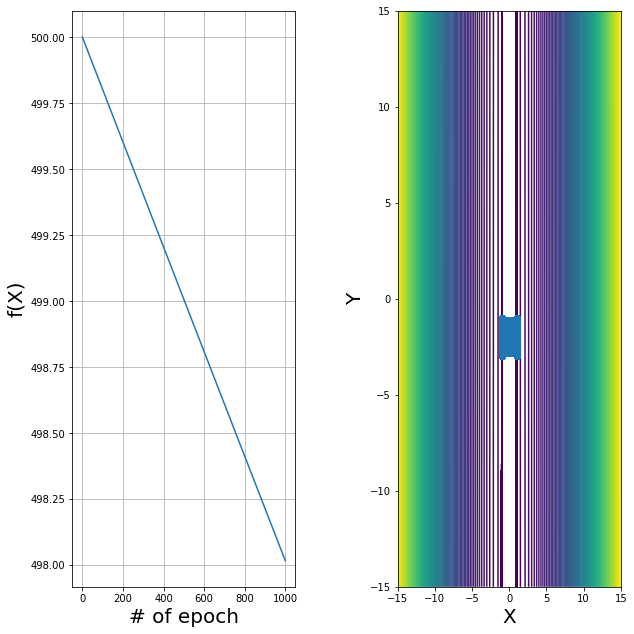

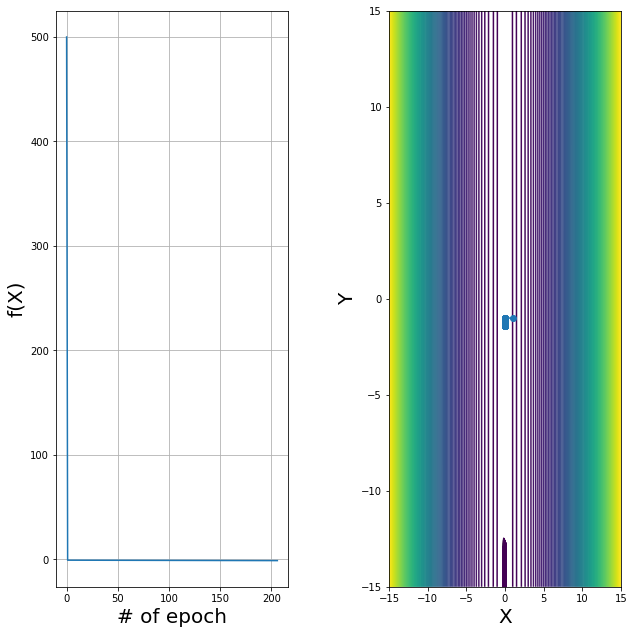

In [ ]:
f = h
lr = 0.002
v_area = ((-15, 15), (-15, 15))
tol = 1.3
_, _, iters, points  = gradient_descent_constant_step(f, numeric_gradient, x0, lr, tol, epoch=epoch)
visualize_descent(points, v_area, print_points = False)
points, _, iters  = grad_descent_with_dichotomy(f, numeric_gradient, x0, lr, tol, epoch=epoch)
visualize_descent(points, v_area, print_points = False)

Градиентный спуск с постоянным шагом ввиду плохой обусловленности показывает тот же эффект, который был замечен ранее: точка постоянно перепрыгивает точку минимума вдоль оси с очень маленьким коэффициентом, в то же время, установленного `learning_rate` не хватает, чтобы за 1000 шагов дойти до минимума вдоль оси с большим коэффициентом. Таким образом, сходимость либо очень медленная, либо её вообще нет, а точность при этом крайне мала: ломанная градиентного спуска с постоянным шагом выглядит как "зигзаг".

#### Масштабирование осей плохо обусловленной функции
#### $f(x,y) = x^2 + y^2 + \frac{1}{\sqrt{500}}x + \frac{1}{\sqrt{0.001}}y$

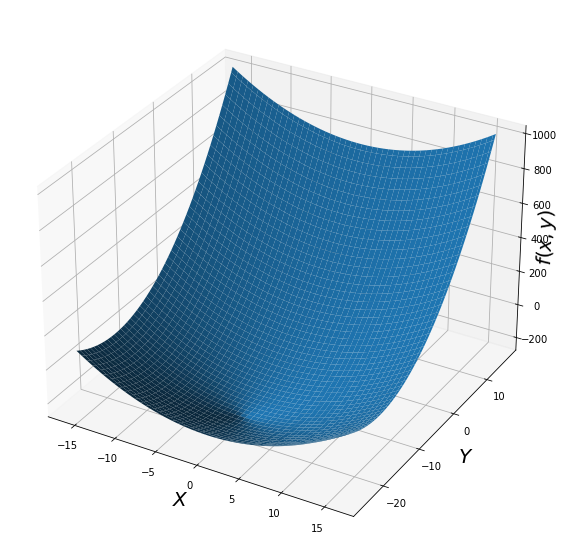

In [ ]:
def h_scaled(x):
    return x[0]**2 + x[1]**2 +1/np.sqrt(500)*x[0] + 1/np.sqrt(0.001)*x[1]
f = h_scaled
v_area = ((-16, 16), (-25, 16))
visualize_2arg(v_area)

Постоянный шаг:

    Начальная точка: [ 1. -1.]
    Количество итераций: 34
    Количество вызовов функции: 34
    Количество вызовов градиента: 34
    Конечная точка: [ -0.02 -15.76]
  


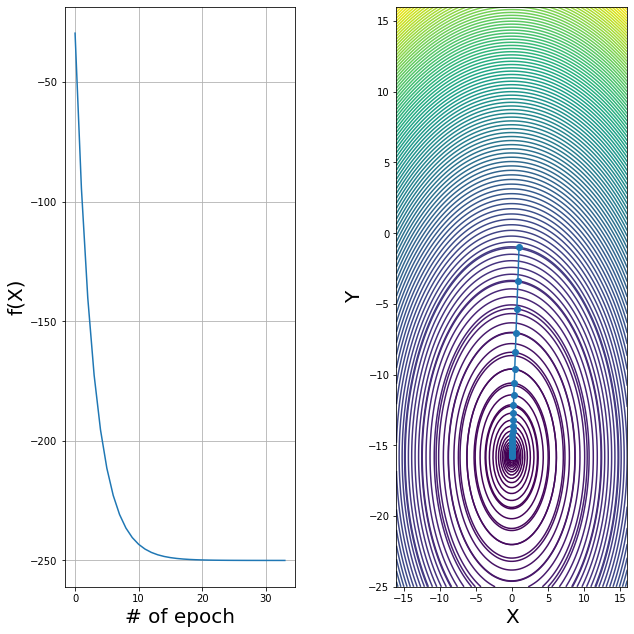

In [ ]:
tol = 0.1
_, _, iters, points = gradient_descent_constant_step(f, numeric_gradient, x0, 0.08, tol, epoch=epoch)
print("Постоянный шаг:")
print_stats(iters, len(points), len(points), points)

visualize_descent(points, v_area, print_points=False)

После масштабирования осей, самый простой градиентный спуск с постоянным шагом плавно, быстро и точно сошёлся к минимуму всего за $36$ шагов. 

Получается, нормализация плохо обусловленной функции кардинально улучшает результаты работы градиентного спуска.

## Задание 5. Реализация генератора случайных квадратичных функций $n$ переменных с числом обусловленности $k$

Для генерации случайной квадратичной функции с $n$ переменными и числом обусловленности $k$ можно использовать следующий алгоритм:

1. Сгенерировать случайную матрицу $A$ размера $n * n$, задав каждый элемент матрицы случайным образом.

2. Симметризовать матрицу $A$.

2. Провести сингулярное разложение матрицы $A$ На матрицы $U$, $S$, $V_H$

3. Применить линейное растяжение для сингулярных чисел, лежащих в матрице $S$ таким образом, чтобы отношение минимального к максимальному из них стало равно $k$

4. Собрать обратно матрицу $A$ из преобразованной тройки $U$, $S$, $V_H$

4. Сгенерировать случайный вектор $B$ размера $n$ и смещение $c$, задав каждый элемент вектора случайным образом.

5. Определить функцию $f(X) = 0.5 * X^T * A * X + B^T * X + c$, где $X \in R^n$.

6. Вернуть полученную функцию $f(X)$.


In [ ]:
def generate_quadratic_function(n, k):
    """
    Генерация случайной квадратичной функции n переменных с числом обусловленности k.
    """
    MAX_VAL = 10
    
    A = (1 - np.random.rand(n, n)) * random.randint(1, MAX_VAL)
    A = (A + A.T)/2
    U, S, VH = np.linalg.svd(A, full_matrices=True)

    mm = np.max(S)
    mn = np.min(S)
    S = mm*(1-((k-1)/k)*(mm-S)/(mm-mn))
    S = np.diag(S)

    A = U@S@VH

    B = (1 - np.random.rand(n)) * random.randint(1, MAX_VAL)
    
    c = (1 - np.random.rand()) * random.randint(1, MAX_VAL)
    return lambda x: np.matmul(np.matmul(np.expand_dims(x, axis=1).T, A), 
                               np.expand_dims(x, axis=0).T).T[0][0] \
                               + np.matmul(B.T, np.expand_dims(x, axis=0).T).T[0] \
                               + c


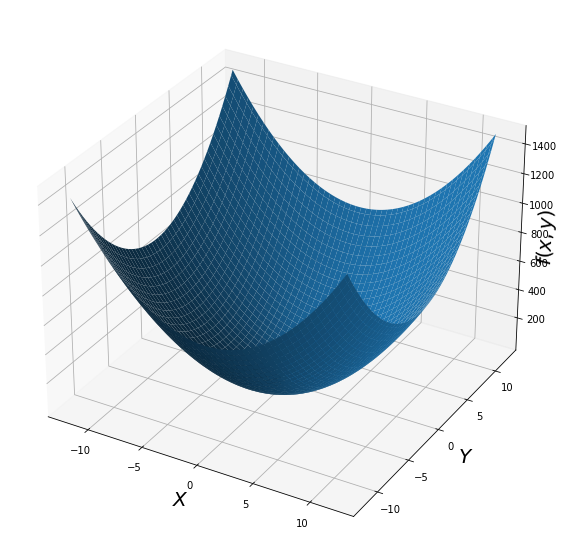

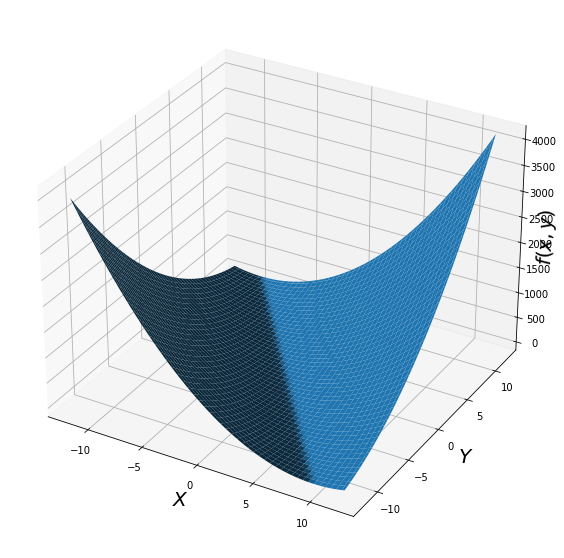

In [ ]:
f = generate_quadratic_function(2, 1)
visualize_2arg()

f = generate_quadratic_function(2, 1000)
visualize_2arg()

Зависимость формы графика функции от $k$ видна невооружённым глазом: при увеличении $k$, график заметно растягивается вдоль одной из осей и сжимается относительно другой оси.

## Задание 6. Исследование зависимости сходимости градиентного спуска от числа обусловленности и размерности пространства функции

In [ ]:
n = 2
k = 1
f = generate_quadratic_function(n, k)
x0 = np.random.rand(n)
lr = 0.008
epoch = 1000
_, _, iters, points = gradient_descent_constant_step(f, numeric_gradient, x0, lr, epoch=1000, tol = 0.1)
print_stats(iters, len(points), len(points), points)
print(np.linalg.norm(points[-1]))


    Начальная точка: [0.45 0.03]
    Количество итераций: 200
    Количество вызовов функции: 200
    Количество вызовов градиента: 200
    Конечная точка: [ 1.80e+10 -1.97e+10]
  
26694493876.188198


Для более детального исследования построем heatmap (цветочную карту) из данных о количестве итераций, которые потребовались для сходимости. Для каждого k и n проверим 10 случайных квадратичных функций, уменьшая lr в зависимости от того, удалось сойтись или нет:

In [ ]:
N, K = np.meshgrid(np.arange(2, 51, 5), np.arange(1, 101, 5))
RES = np.zeros(N.shape)

for x in range(N.shape[0]):
  lr = 0.08
  for y in range(N.shape[1]):
    print("Progress: ", (x, y))
    mean = []
    for i in range(10):
      while True:
        f = generate_quadratic_function(N[x, y], K[x, y])
        x0 = np.random.rand(N[x, y])
        epoch = 500
        _, _, iters, points = gradient_descent_constant_step(f, numeric_gradient, x0, lr, epoch = epoch, tol = 1)
        if len(points) >= epoch:  # Не успело сойтись за epoch, пропускаем
          break
        if np.linalg.norm(points[-1]) < 10:
          mean.append(len(points))  # Сошлось
          break
        lr /= 10  # Не сошлось, пробуем медленнее
        print('lr decrease')
    if len(mean) == 0:
      RES[x, y] = np.inf
      print("inf")
    else:
      RES[x, y] = sum(mean) / len(mean)
      print(RES[x, y])

Progress:  (0, 0)
lr decrease -2.88563432083976e+21
-893.1180525399878 False
-20343.456757774056 False
-555.4192372260527 False
-917.5943474797047 False
-58.28361117730046 False
35.0
Progress:  (0, 1)
lr decrease -9.93451036391967e+25
-1299028.0287137027 False
lr decrease -3.941403189636466e+22
-145522.78497694433 False
-1406.5078462221716 False
-23932.042497110866 False
-1509069.1135976058 False
-464021.94079881423 False
-196043.5238163468 False
-2273.839463627824 False
-3821187.0899776043 False
-3540222.833426945 False
inf
Progress:  (0, 2)
-2671761.246621865 False
-6228302315.332026 False
-157793716815.55795 False
-5081236382.02654 False
-25863946797.664898 False
-363811.9442295512 False
-170177601930.09134 False
-191326492302.96414 False
-20975369.53501072 False
-702645855.6943065 False
inf
Progress:  (0, 3)
-6705812967013.949 False
-573524878685.9471 False
-536625962694.57605 False
-10572237.40208915 False
-105244033350705.47 False
-7316327805568.308 False
-504052782325.5863 False

KeyboardInterrupt: ignored

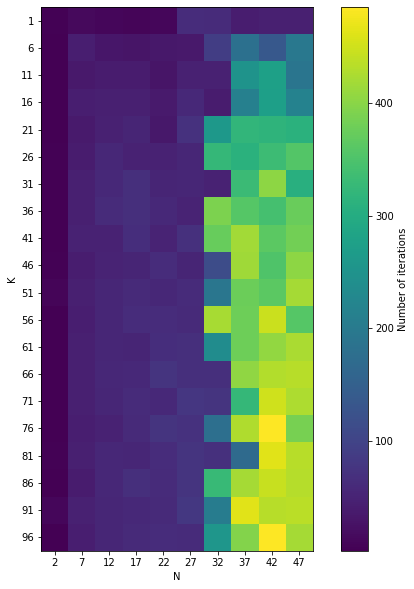

In [ ]:
heatmap2d(N, K, RES, "N", "K")

Из этого графика можно сделать следующие выводы:

1. При увеличении размерности пространства n, требуется больше итераций для сходимости. Это объясняется тем, что при увеличении размерности пространства, количество точек для проверки увеличивается.

2. При увеличении числа обусловленности k, также требуется больше итераций для сходимости градиентного спуска. Чем выше обусловленность, тем больше будет вариация значений функции в разных направлениях, и тем сложнее будет определить оптимальное направление движения для спуска.

Заметно, что влияние числа обусловленности k на количество итераций для сходимости спуска не такое сильное, как влияние размерности пространства n. Однако, при больших значениях k (больше 100, например), это влияние может стать более заметным.

## Задание 7. Реализация одномерного поиска с учётом условий Вольфе. Исследование его эффективности.

Вспомним, что условиями Вольфе (Wolfe conditions) называются утверждения:

1. $f(x_k +  \alpha_k \cdot p_k) \le f(x_k) + c_1 \alpha_k \nabla f_k^T p_k $ (Armijo condition)
2. $\nabla f (x_k + \alpha_k p_k)^{T}p_k \ge c_2 \nabla f_k^{T}p_k$ (curvature condition)

Первое требует, чтобы с каждым шагом (итерацией) функция существенно уменьшалась, а второе --- чтобы наклон градиента также был достаточно уменьшен (за достаточность и существенность отвечают коэффициенты $c_1, c_2$)

Теперь реализуем метод одномерного поиска с проверкой найденного `learning_rate` на соответствие условиям Вольфе.

### Реализация

In [ ]:
def gradient_descent_with_wolfe_conditions(
    f, df, x0, c1=0.01, c2=0.9, tol=1e-6, epoch=1000
):
    """
    Градиентный спуск с условиями Вольфе

    f : function
        Функция для минимизации
    df : function
        Функция градиента
    x0 : ndarray[0]
        Начальная точка
    alpha : float
        Шаг спуска (learning_rate)
    beta : float
        Уменьшающий множитель для alpha
    tol : float
        Отсекающее значение для нормы градиента
    epoch : int,
        Максимальное количество итераций

    Возвращаеммы значения
    -------
    x : ndarray
        Последняя точка пути
    f_x : float
        Значение в последней точке
    iter : int
        Количество итераций
    points : list
        Список шагов
    f_calls : int
        Количество вызовов функции
    df_calls : int 
        Количество вызовов градиента
    """
    f_calls = 1
    df_calls = 1
    points = [x0]
    x = x0
    f_x = f(x)
    grad_f_x = df(f, x)
    iters = 0

    while np.linalg.norm(grad_f_x) > tol and iters < epoch: # отсечение
        d = -grad_f_x
        t = 1.0

        while (
            t > tol and (f(x + t * d) > f_x + c1 * t * grad_f_x.dot(d)
            or df(f, x + t * d).dot(d) < c2 * grad_f_x.dot(d))
        ): # пока не выполняются условия Вольфе, уменьшаем шаг
            t *= c2
            f_calls += 1
            df_calls += 1
        
        x = x + t * d
        points.append(x)
        f_x = f(x)
        grad_f_x = df(f, x)

        f_calls += 1
        df_calls += 1
        iters += 1

    return x, f_x, iters, points, f_calls, df_calls

### Исследование

Рассмотрим на примере наших функций $g, h, w$ при параметрах `epoch = 1000`, $x_0 = (-1, 1)$:

In [ ]:
x0 = np.array([-1.0, 1.0])
epoch = 1000

NameError: ignored

In [ ]:
def analyze_start_points_and_functions_call(f, lr=lr, tol=def_tol, epoch=epoch):
    print("|Начальная точка | Конечная точка при пост. шаге|Конечная точка при дихотомии| Конечная точка при ус. Вольфа | К-во шагов при пост. шаге| К-во шагов при дихотомии| К-во шагов при ус. Вольфа | К-во вызовов f при пост. шаге | К-во вызовов f при м. дихотомии | К-во вызовов f при ус. Вольфа |")
    print("|-|-|-|-|-|-|-|-|-|-|")
    for i in start_points:
        _, _, iters, points1 = gradient_descent_constant_step(f, numeric_gradient, i, lr, epoch=epoch, tol=tol)
        points2, func_calls2, grad_calls2 = grad_descent_with_dichotomy(f, numeric_gradient, i, lr, epoch=epoch, tol=tol)
        _, _, iters3, points3, func_calls3, grad_calls3 = gradient_descent_with_wolfe_conditions(f, numeric_gradient, x0=i, epoch=epoch)
        print(f"|{i} | {points1[-1]}|{points2[-1]}|{points3[-1]}|{len(points1)}| {len(points2)}|{len(points3)}|{len(points1) * 3} | {func_calls2 + 2 * grad_calls2} | {func_calls3 + 2 * grad_calls3} |")

In [ ]:
_, р, iters, points, f_count, df_count = gradient_descent_with_wolfe_conditions(f=g, df=numeric_gradient, x0=x0, epoch=epoch)
print_stats(iters, f_count, df_count, points)
visualize_descent(points)

In [ ]:
analyze_start_points_and_functions_call(g)

|Начальная точка | Конечная точка при пост. шаге|Конечная точка при дихотомии| Конечная точка при ус. Вольфа | К-во шагов при пост. шаге| К-во шагов при дихотомии| К-во шагов при ус. Вольфа | К-во вызовов f при пост. шаге | К-во вызовов f при м. дихотомии | К-во вызовов f при ус. Вольфа |
|-|-|-|-|-|-|-|-|-|-|
|[0. 0.] | [0. 0.]|[0. 0.]|[0. 0.]|1| 1|1|3 | 2 | 3 |
|[0.5 0.5] | [0.01 0.  ]|[0.01 0.  ]|[ 6.44e-12 -7.44e-12]|1001| 1000|3|3003 | 21980 | 18 |
|[ 0.5 -0.5] | [ 0.01 -0.  ]|[ 0.01 -0.  ]|[6.44e-12 7.44e-12]|1001| 1000|3|3003 | 21980 | 18 |
|[-3. -3.] | [-0.05 -0.  ]|[-0.05 -0.  ]|[-1.36e-10 -3.58e-10]|1001| 1000|3|3003 | 21980 | 18 |
|[-3.  3.] | [-0.05  0.  ]|[-0.05  0.  ]|[-1.36e-10  3.58e-10]|1001| 1000|3|3003 | 21980 | 18 |
|[3. 0.] | [0.05 0.  ]|[0.05 0.  ]|[-4.19e-10  0.00e+00]|1001| 1000|2|3003 | 21980 | 9 |
|[-3.  0.] | [-0.05  0.  ]|[-0.05  0.  ]|[4.19e-10 0.00e+00]|1001| 1000|2|3003 | 21980 | 9 |
|[0. 3.] | [0. 0.]|[0. 0.]|[ 0.00e+00 -4.19e-10]|1001| 1000|2|3003 | 21980 | 12 |
|[ 0. -3.] | [ 0. -0.]|[ 0. -0.]|[0.00e+00 4.19e-10]|1001| 1000|2|3003 | 21980 | 12 |
|[100. 100.] | [1.82 0.03]|[1.83 0.03]|[-2.02e-07 -2.02e-07]|1001| 1000|3|3003 | 21980 | 18 |
|[-100. -100.] | [-1.82 -0.03]|[-1.83 -0.03]|[2.02e-07 2.02e-07]|1001| 1000|3|3003 | 21980 | 18 |
|[-100.    0.] | [-1.82  0.  ]|[-1.83  0.  ]|[-2.52e-07  0.00e+00]|1001| 1000|2|3003 | 21980 | 9 |
|[  0. 100.] | [0.   0.03]|[0.   0.03]|[0.00e+00 5.29e-23]|1001| 1000|3|3003 | 21980 | 21 |


In [ ]:
_, р, iters, points, f_count, df_count = gradient_descent_with_wolfe_conditions(f=h, df=numeric_gradient, x0=x0, epoch=epoch)
print_stats(iters, f_count, df_count, points)
visualize_descent(points)

In [ ]:
analyze_start_points_and_functions_call(h)

|Начальная точка | Конечная точка при пост. шаге|Конечная точка при дихотомии| Конечная точка при ус. Вольфа | К-во шагов при пост. шаге| К-во шагов при дихотомии| К-во шагов при ус. Вольфа | К-во вызовов f при пост. шаге | К-во вызовов f при м. дихотомии | К-во вызовов f при ус. Вольфа |
|-|-|-|-|-|-|-|-|-|-|
|[0. 0.] | [ 1.33e-13 -2.00e+00]|[-1.46e-03 -1.99e+00]|[-6.73e-05 -2.03e+00]|1001| 1000|1001|3003 | 21980 | 29874 |
|[0.5 0.5] | [ 0.5 -1.5]|[-1.23e-03 -1.49e+00]|[ 4.29e-04 -5.67e+00]|1001| 1000|1001|3003 | 21980 | 29259 |
|[ 0.5 -0.5] | [ 0.5  -2.49]|[-1.23e-03 -2.49e+00]|[ 7.25e-04 -6.79e+00]|1001| 1000|1001|3003 | 21980 | 29238 |
|[-3. -3.] | [-3.   -4.98]|[-8.46e-04 -4.98e+00]|[-2.69e-03 -5.02e+00]|1001| 1000|1001|3003 | 21980 | 29880 |
|[-3.  3.] | [-3.    0.99]|[-8.40e-04  9.97e-01]|[-0.    0.96]|1001| 1000|1001|3003 | 21980 | 29880 |
|[3. 0.] | [ 3. -2.]|[-1.16e-03 -1.99e+00]|[ 6.92e-04 -2.03e+00]|1001| 1000|1001|3003 | 21980 | 29880 |
|[-3.  0.] | [-3. -2.]|[-8.43e-04 -1.99e+00]|[-0.   -2.03]|1001| 1000|1001|3003 | 21980 | 29880 |
|[0. 3.] | [-1.42e-11  9.92e-01]|[-0.    0.99]|[-6.73e-05  9.55e-01]|1001| 1000|1001|3003 | 21980 | 29874 |
|[ 0. -3.] | [-4.00e-12 -4.98e+00]|[-1.45e-03 -4.98e+00]|[-6.73e-05 -5.02e+00]|1001| 1000|1001|3003 | 21980 | 29874 |
|[100. 100.] | [100.   97.6]|[-9.56e-04  9.76e+01]|[-2.39e-03  9.76e+01]|1001| 1000|1001|3003 | 21980 | 29883 |
|[-100. -100.] | [-100.  -101.6]|[-9.56e-04 -1.02e+02]|[ 3.87e-04 -1.02e+02]|1001| 1000|1001|3003 | 21980 | 29883 |
|[-100.    0.] | [-100.   -2.]|[-9.56e-04 -1.99e+00]|[ 3.87e-04 -2.03e+00]|1001| 1000|1001|3003 | 21980 | 29883 |
|[  0. 100.] | [-9.95e-11  9.76e+01]|[-1.46e-03  9.76e+01]|[1.84e-03 9.76e+01]|1001| 1000|1001|3003 | 21980 | 29871 |

In [ ]:
_, р, iters, points, f_count, df_count = gradient_descent_with_wolfe_conditions(f=w, df=numeric_gradient, x0=x0, epoch=epoch)
print_stats(iters, f_count, df_count, points)
visualize_descent(points)

In [ ]:

analyze_start_points_and_functions_call(w, epoch=1000)

|Начальная точка | Конечная точка при пост. шаге|Конечная точка при дихотомии| Конечная точка при ус. Вольфа | К-во шагов при пост. шаге| К-во шагов при дихотомии| К-во шагов при ус. Вольфа | К-во вызовов f при пост. шаге | К-во вызовов f при м. дихотомии | К-во вызовов f при ус. Вольфа |
|-|-|-|-|-|-|-|-|-|-|
|[0. 0.] | [-0.25  0.25]|[-0.25  0.25]|[-0.25  0.25]|1001| 1000|2|3003 | 21980 | 12 |
|[0.5 0.5] | [0.25 0.75]|[0.25 0.75]|[0.25 0.75]|1001| 1000|2|3003 | 21980 | 12 |
|[ 0.5 -0.5] | [-0.25  0.25]|[-0.25  0.25]|[-0.25  0.25]|1001| 1000|2|3003 | 21980 | 12 |
|[-3. -3.] | [-3.25 -2.75]|[-3.25 -2.75]|[-3.25 -2.75]|1001| 1000|2|3003 | 21980 | 12 |
|[-3.  3.] | [-0.25  0.25]|[-0.25  0.25]|[-0.25  0.25]|1001| 1000|2|3003 | 21980 | 12 |
|[3. 0.] | [1.25 1.75]|[1.25 1.75]|[1.25 1.75]|1001| 1000|2|3003 | 21980 | 12 |
|[-3.  0.] | [-1.75 -1.25]|[-1.75 -1.25]|[-1.75 -1.25]|1001| 1000|2|3003 | 21980 | 12 |
|[0. 3.] | [1.25 1.75]|[1.25 1.75]|[1.25 1.75]|1001| 1000|2|3003 | 21980 | 12 |
|[ 0. -3.] | [-1.75 -1.25]|[-1.75 -1.25]|[-1.75 -1.25]|1001| 1000|2|3003 | 21980 | 12 |
|[100. 100.] | [ 99.75 100.25]|[ 99.75 100.25]|[ 99.75 100.25]|1001| 1000|5|3003 | 21980 | 102 |
|[-100. -100.] | [-100.25  -99.75]|[-100.25  -99.75]|[-100.25  -99.75]|1001| 1000|5|3003 | 21980 | 102 |
|[-100.    0.] | [-50.27 -49.73]|[-50.27 -49.73]|[-50.25 -49.75]|1001| 1000|2|3003 | 21980 | 12 |
|[  0. 100.] | [49.73 50.27]|[49.73 50.27]|[49.75 50.25]|1001| 1000|5|3003 | 21980 | 156 |

### Вывод

Как показали результаты испытаний, на обычных, "не сильно плохих" функциях, такой метод оптимизации работает **гораздо** эффективнее (примеры $g, w$ показывают, что при равных стартовых данных, метод с учётом условий Вольфа справляется за 2-3 итерации, в то время как константному и методу дихотомии требуется ~ epoch итераций), однако, в силу специфики подбора, на одну итерацию требуется больше вызовов функции

# Заключение
В данной работе были рассмотрены различные методы градиентного спуска на различных функциях.

Исследование показало, что использование градиентного спуска с постоянным шагом может быть неэффективным для функций, которые имеют плохую обусловленность. В таких случаях градиентный спуск может не сойтись к оптимальному значению, если шаг обучения выбран неправильно. В этом случае помогает метод дихотомии, так как он уменьшает шаг окрестности минимума, что уменьшает флуктуации спуска.

Выбор начальной точки может повлиять на сходимость градиентного спуска. Если точек минимума несколько, выбор начальной точки может поменять конечную точку, к которой сойдётся градиентный спуск.

Нормализация плохо обусловленной функции кардинально улучшает результаты работы градиентного спуска. При использовании нормализации градиентный спуск быстро и точно сошелся к минимуму за 36 шагов.

При увеличении размерности пространства и числа обусловленности исследуемой функции, требуется больше итераций для сходимости. При больших значениях числа обусловленности, влияние на количество итераций для сходимости становится более заметным.
